In [1]:
# Get tree measurements for year 82, 85, and 90
import pandas as pd
treeMeasurements = pd.read_csv("C55_TreeMeasurements.csv")

#getting trees from 1982 and 1985 measurements
desiredCols1 = ["PLOT", "TREE", "RECRUIT", "SPECIES", "D82", "D85"]
customMeasurements1 = treeMeasurements[desiredCols1]

#getting trees from 1985 to 1990
desiredCols2 = ["PLOT", "TREE", "RECRUIT", "SPECIES", "D85", "D90"]
customMeasurements2 = treeMeasurements[desiredCols2]

#cleaning data to gather trees that only have measurements at both ends of the period
clean82_85 = customMeasurements1.dropna()
clean85_90 = customMeasurements2.dropna()

In [2]:
# getting foliar nutrients from csv file
foliarNutrients = pd.read_csv("C55_FoliarNutrients.csv")
foliarNutrients = foliarNutrients.drop("REPLICATE", axis=1)

# Get foliar nutrient levels 1982
foliarNutrients82 = foliarNutrients.loc[foliarNutrients['YEAR'] == 1982]

# Get foliar nutrient levels 1985
foliarNutrients85 = foliarNutrients.loc[foliarNutrients['YEAR'] == 1985]

In [3]:
# Add foliar nutrients to tree data 
allTreeData82_85 = pd.merge(clean82_85, foliarNutrients82, on="PLOT", how="outer")
allTreeData85_90 = pd.merge(clean85_90, foliarNutrients85, on="PLOT", how="outer")

In [4]:
# Getting percent growth for each tree per year
# perc_growth = (D85-D82)/D82
allTreeData82_85["Growth"] = (allTreeData82_85["D85"]-allTreeData82_85["D82"])/allTreeData82_85["D82"]
# growth_per_yr = prec_growth/85-82
allTreeData82_85["Growth/yr"] = allTreeData82_85["Growth"]/3

#getting percent growth for 1985-1990
# perc_growth = (D90-D85)/D825
allTreeData85_90["Growth"] = (allTreeData85_90["D90"]-allTreeData85_90["D85"])/allTreeData85_90["D85"]
# growth_per_yr = prec_growth/85-82
allTreeData85_90["Growth/yr"] = allTreeData85_90["Growth"]/5

In [5]:
# Extract relevant columns: 
relColumns = ["SPECIES", "TOTN", "TOTP", "TOTK", "TOTS", "TOTCa", "Growth/yr"]
modelingData82 = allTreeData82_85[relColumns]
modelingData85 = allTreeData85_90[relColumns]

# combine dataframes to make one dataframe with all data needed
modelingData = pd.concat([modelingData82, modelingData85], ignore_index=True)
modelingData['id'] = modelingData.index

In [ ]:
#Either jump to regression, or keep going to do classification

<AxesSubplot:xlabel='bins'>

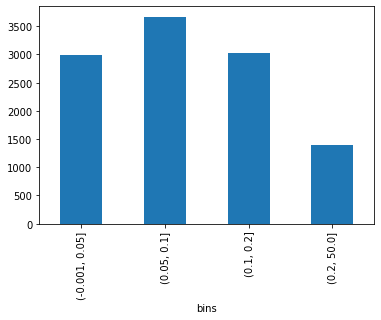

In [7]:
# Experimental data analysis looking at distribution and possible binning
import matplotlib

# creating a copy of current modeling data
modelingCopy = modelingData

# Creating Histogram for percent growth per year
bins = [0, .05, .1, .2, 50]
modelingCopy['bins'] = pd.cut(modelingData['Growth/yr'], bins = bins, include_lowest=True)
plotDF = modelingCopy.groupby('bins').bins.count()
plotDF.plot(kind="bar")


In [7]:
# Getting Columns for neural network classification
# What bin does the growth/yr fall into? that bin gets a 1, others get 0

mergeDF = pd.DataFrame(columns=['id', 'bin'])

# For each row in modelingData setting a bin based off how growth/year
for index, row in modelingData.iterrows():
    #bins: 0-0.05, 0.05+ to 0.1, 0.1+ to 0.2, 0.2+
    if row['Growth/yr'] <= .05:
        mergeDF.loc[index] = pd.Series({'id': index, 'bin': 0})
    elif row['Growth/yr'] <= .1:
        mergeDF.loc[index] = pd.Series({'id': index, 'bin': 1})
    elif row['Growth/yr'] <= .2:
        mergeDF.loc[index] = pd.Series({'id': index, 'bin': 2})
    else:
        mergeDF.loc[index] = pd.Series({'id': index, 'bin': 3})

# joining data to include bin
modelingData = pd.merge(modelingData, mergeDF, on='id', how="outer")

In [8]:
# Getting data ready for the Classification Neural Network

# Input variables: SPECIES, TOTN, TOTP, TOTK, TOTS, TOTCa, and TOTMg (not used)
# label: fixed bins (1 for correct bin, 0 for all others)
classifyColumns = ['SPECIES', 'TOTN', 'TOTP', 'TOTK', 'TOTS', 'TOTCa', 'bin']
classifyData = modelingData[classifyColumns]

# for turning 'species' column into numerical data
from sklearn.preprocessing import LabelEncoder
speciesLabEncoder = LabelEncoder()

# Transforms species into numerical data
speciesNumList = speciesLabEncoder.fit_transform(classifyData['SPECIES'])
# code for reverting: species = le.inverse_transform(label)
# changing the species column to numerical values
classifyData['SPECIES'] = speciesNumList

<ipython-input-8-3f59790ad1d2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifyData['SPECIES'] = speciesNumList


In [9]:
# Splitting into input and output data
classifyX = classifyData.iloc[:,:6].values
classifyY = classifyData.iloc[:,6:7].values

# Transforming output into binary values
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
classifyY = ohe.fit_transform(classifyY).toarray()

In [10]:
# Splitting data into training and test data
from sklearn.model_selection import train_test_split
classifyX_train, classifyX_test, classifyY_train, classifyY_test = train_test_split(classifyX, classifyY, test_size = 0.1)

In [93]:
#Building and Compiling Neural Network for Classification
import keras
from keras.models import Sequential
from keras.layers import Dense

classifyModel = Sequential()
classifyModel.add(Dense(24, input_dim=6, activation='relu'))
classifyModel.add(Dense(24, activation='relu'))
#trying to overfit
classifyModel.add(Dense(36, activation='relu'))
classifyModel.add(Dense(36, activation='relu'))
classifyModel.add(Dense(24, activation='relu'))
classifyModel.add(Dense(12, activation='relu'))
classifyModel.add(Dense(4, activation='sigmoid'))

classifyModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
#Training classification model
training = classifyModel.fit(classifyX_train, classifyY_train, epochs=100, batch_size=64)

Epoch 1/100
156/156 [==============================] - 2s 2ms/step - loss: 1.3282 - accuracy: 0.4311
Epoch 2/100
156/156 [==============================] - 0s 3ms/step - loss: 1.1120 - accuracy: 0.4983
Epoch 3/100
156/156 [==============================] - 0s 3ms/step - loss: 1.0628 - accuracy: 0.5002
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 1.0326 - accuracy: 0.5192
Epoch 5/100
156/156 [==============================] - 0s 3ms/step - loss: 1.0210 - accuracy: 0.5301
Epoch 6/100
156/156 [==============================] - 0s 3ms/step - loss: 1.0178 - accuracy: 0.5154
Epoch 7/100
156/156 [==============================] - 1s 5ms/step - loss: 1.0086 - accuracy: 0.5251
Epoch 8/100
156/156 [==============================] - 1s 4ms/step - loss: 1.0062 - accuracy: 0.5239
Epoch 9/100
156/156 [==============================] - ETA: 0s - loss: 1.0110 - accuracy: 0.53 - 0s 2ms/step - loss: 1.0105 - accuracy: 0.5332
Epoch 10/100
156/156 [===========================

In [95]:
#Testing classification model
import numpy as np
prediction = classifyModel.predict(classifyX_test)

# undoing onehot encoder
pred = list()
for i in range(len(prediction)):
    pred.append(np.argmax(prediction[i]))
test = list()
for i in range(len(classifyY_test)):
    test.append(np.argmax(classifyY_test[i]))

In [96]:
# Determining accuracy of Classification Neural Network model
from sklearn.metrics import accuracy_score
classifyAccuracy = accuracy_score(pred,test)
print('Accuracy is:', classifyAccuracy)

Accuracy is: 0.5727190605239386


In [7]:
# Getting Columns for neural network regression
# input variables: SPECIES, TOTN, TOTP, TOTK, TOTS, TOTCa, and TOTMg (not used)
# label: predicting growth per year

regressColumns = ['SPECIES', 'TOTN', 'TOTP', 'TOTK', 'TOTS', 'TOTCa', 'Growth/yr']
regressData = modelingData[regressColumns]

# for turning 'species' column into numerical data
from sklearn.preprocessing import LabelEncoder
speciesLabEncoder = LabelEncoder()

# Transforms species into numerical data
speciesNumList = speciesLabEncoder.fit_transform(regressData['SPECIES'])
# code for reverting: species = le.inverse_transform(label)
# changing the species column to numerical values
regressData['SPECIES'] = speciesNumList

<ipython-input-7-43b84e18647f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressData['SPECIES'] = speciesNumList


In [9]:
# Splitting into input and output data
regressX = regressData.iloc[:,:6].values
regressY = regressData.iloc[:,6:7].values

import numpy as np
from sklearn.preprocessing import MinMaxScaler
regressY = np.reshape(regressY, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print (scaler_x.fit(regressX))
xscale = scaler_x.transform(regressX)
print (scaler_y.fit(regressY))
yscale = scaler_y.transform(regressY)

MinMaxScaler()
MinMaxScaler()


In [10]:
# Splitting data into training and test data
from sklearn.model_selection import train_test_split
regressX_train, regressX_test, regressY_train, regressY_test = train_test_split(xscale, yscale, test_size = 0.2)


In [37]:
#Building and Compiling Neural Network for Regression
import keras
from keras.models import Sequential
from keras.layers import Dense

regressModel = Sequential()
regressModel.add(Dense(12, input_dim = 6, kernel_initializer='normal', activation='relu'))
regressModel.add(Dense(12, activation='relu'))
regressModel.add(Dense(1, activation='linear'))
# 6/12/12/1
#regressModel.summary()
loss_function = keras.losses.MeanAbsoluteError()
regressModel.compile(loss=loss_function, optimizer='adam', metrics=['mse','mae','mape'])


In [41]:
#Training model
# regressY_train = regressY_train + 0.000001
regressModel.fit(regressX_train, regressY_train, epochs=150, batch_size=50)

Epoch 1/150
178/178 [==============================] - 0s 2ms/step - loss: 0.0099 - mse: 5.6088e-04 - mae: 0.0099 - mape: 8212.4834
Epoch 2/150
178/178 [==============================] - 1s 3ms/step - loss: 0.0098 - mse: 5.6105e-04 - mae: 0.0098 - mape: 7944.0615
Epoch 3/150
178/178 [==============================] - 1s 3ms/step - loss: 0.0098 - mse: 5.5965e-04 - mae: 0.0098 - mape: 8156.7031
Epoch 4/150
178/178 [==============================] - 1s 3ms/step - loss: 0.0098 - mse: 5.6089e-04 - mae: 0.0098 - mape: 8015.4580
Epoch 5/150
178/178 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 5.6468e-04 - mae: 0.0098 - mape: 8071.4922
Epoch 6/150
178/178 [==============================] - 1s 3ms/step - loss: 0.0098 - mse: 5.6109e-04 - mae: 0.0098 - mape: 7946.0601
Epoch 7/150
178/178 [==============================] - 0s 3ms/step - loss: 0.0098 - mse: 5.6062e-04 - mae: 0.0098 - mape: 8220.0664
Epoch 8/150
178/178 [==============================] - 0s 3ms/step - loss: 0

In [42]:
prediction = regressModel.predict(regressX_test)
pred = scaler_y.inverse_transform(prediction)
true = scaler_y.inverse_transform(regressY_test)
# true = true + 0.000001

#from sklearn.metrics import mean_absolute_percentage_error as mape
#print("Mean Absolute Percentage Error: ", mape(true, pred))

from sklearn.metrics import mean_absolute_error as mae
print("Mean Absolute Error: ", mae(true, pred))

from sklearn.metrics import max_error
print("Max Error: ", max_error(true, pred))

absErrors = abs(true - pred)

# making a histogram
import matplotlib.pyplot as plt


# Creating Histogram for percent growth per year
#bins = [0, .05, .1, .2, 50]
#modelingCopy['bins'] = pd.cut(modelingData['Growth/yr'], bins = bins, include_lowest=True)
#plotDF = modelingCopy.groupby('bins').bins.count()
#plotDF.plot(kind="bar")


Mean Absolute Error:  0.04062351749407305
Max Error:  2.1302025814851127
